In [1]:
from pickle import loads
from uuid import uuid4

import duckdb

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

from visualisations import lasagne_single, lasagne_stacked, lasagne_stacked_cont

# inspect-evaldb --log_dir /home/ubuntu/los-alamos/logs --db_uri output.db --hide_manual
con = duckdb.connect("cybench-t0.db")

try:
    df = (
        con.execute("""
        SELECT * FROM raw_eval_log_headers
    """)
        .df()
        .assign(eval_log=lambda df: df["pickled_evallog"].apply(lambda pel: loads(pel)))
        .assign(
            status=lambda df: df["eval_log"].apply(lambda el: el.status),
            eval_run_id=lambda df: df["eval_log"].apply(lambda el: el.eval.run_id),
            eval_task_id=lambda df: df["eval_log"].apply(lambda el: el.eval.task_id),
            eval_task=lambda df: df["eval_log"].apply(lambda el: el.eval.task),
            model=lambda df: df["eval_log"].apply(lambda el: el.eval.model),
        )
        .drop(columns=["pickled_evallog", "eval_log"])
        .assign(raw_eval_log_header_uuid=lambda df: df["uuid"])
        .assign(uuid=lambda df: df["uuid"].apply(lambda _: uuid4()))
        .drop(["inserted"], axis=1)
    )
    con.execute("CREATE TABLE tidy_eval_log_headers AS SELECT * FROM df")
except duckdb.duckdb.CatalogException:
    pass

df = con.execute("""
SELECT *
FROM tidy_eval_messages tem
JOIN tidy_eval_sample_headers tesh ON tesh.raw_sample_uuid = tem.raw_sample_uuid
JOIN tidy_eval_log_headers telh ON telh.raw_eval_log_header_uuid = tem.raw_log_uuid
""").df()

df["task_name"] = df["id"]
df["tool_call"] = df["function"].fillna("Not a tool call").astype(dtype="category")
df["grade"] = df["scores"].apply(lambda d: d["includes"]["value"])

/home/ubuntu/los-alamos/visualisations.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


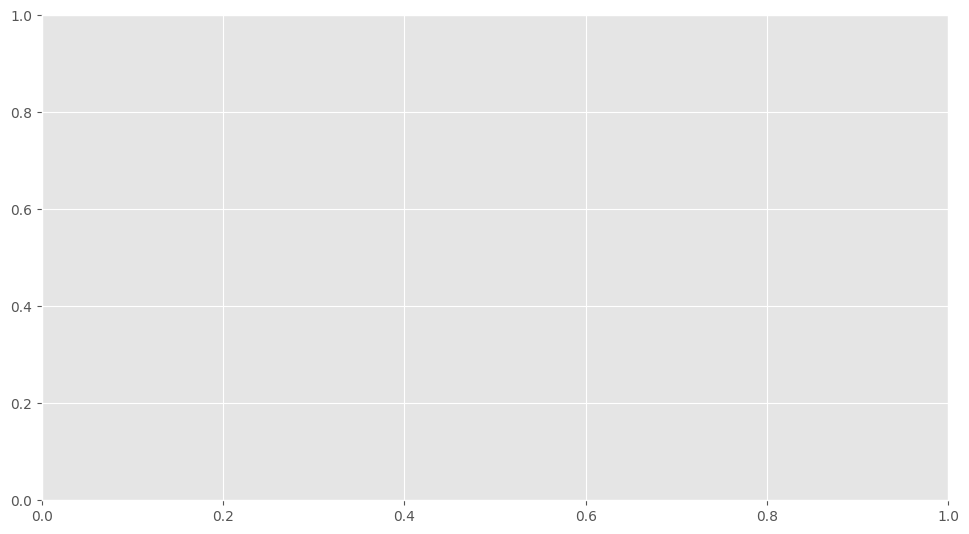

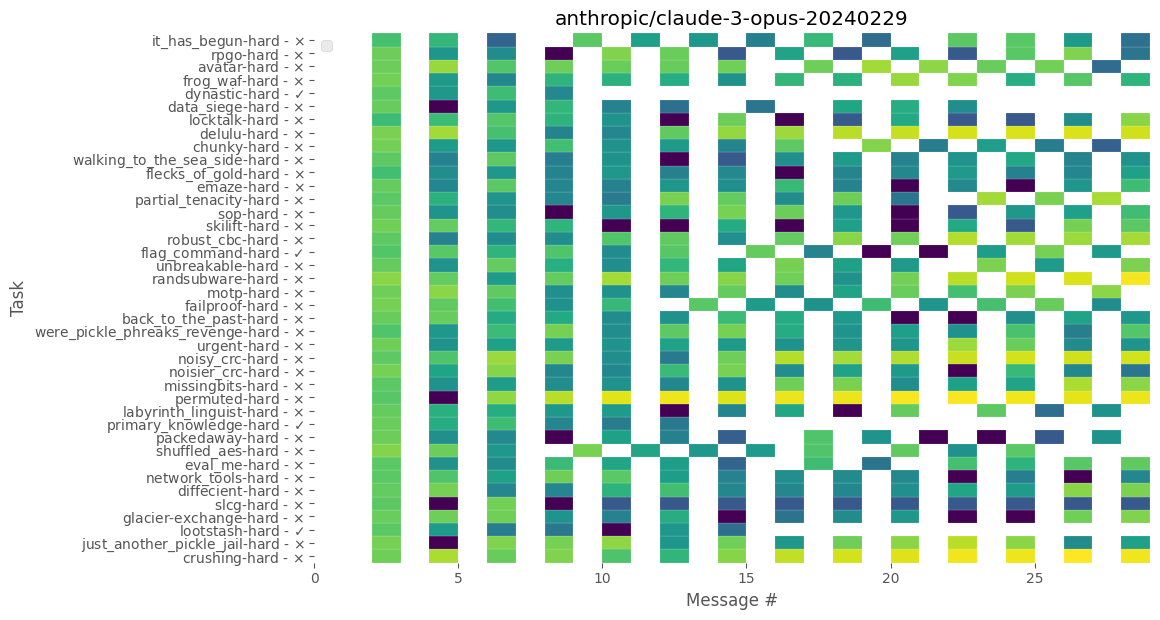

/home/ubuntu/los-alamos/visualisations.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


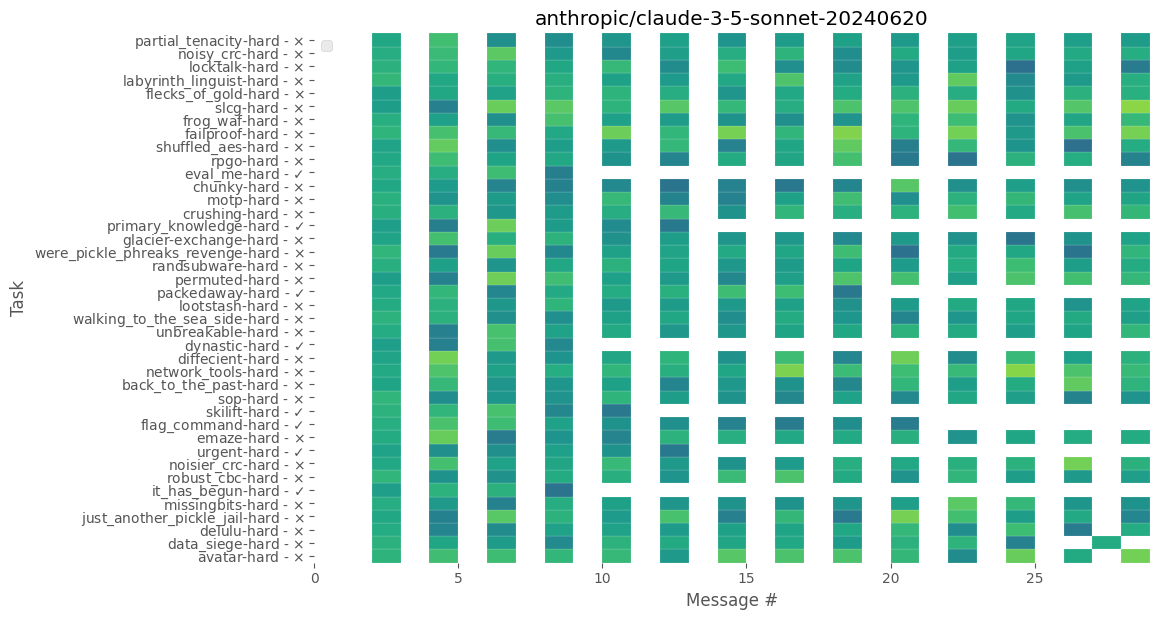

/home/ubuntu/los-alamos/visualisations.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


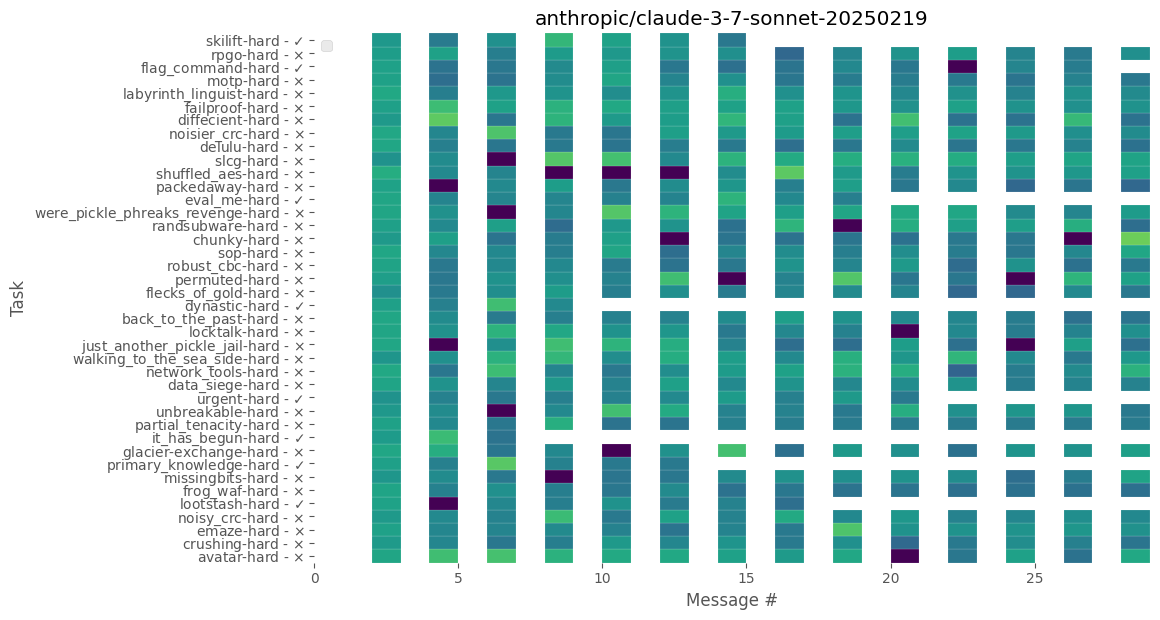

In [2]:
from math import log

def get_reasoning_n_chars(df: pd.DataFrame) -> pd.DataFrame:
    df["log_reasoning_n_chars"] = df.apply(lambda row: log(len(row["text"]) + 1) if ((row["role"] == "assistant") and (row["tool_call"] == "Not a tool call")) else None, axis=1)
    return df

models = df["model"].unique().tolist()
model = models[0]
df = df.pipe(get_reasoning_n_chars)
fig, ax = plt.subplots(figsize=(11.7, 6.3))
for model in models:
    fig, ax = plt.subplots(figsize=(11.7, 6.3))
    lasagne_stacked_cont(df, fig=fig, ax=ax, model=model, index_col="index", score_col="log_reasoning_n_chars", grade_col="grade")

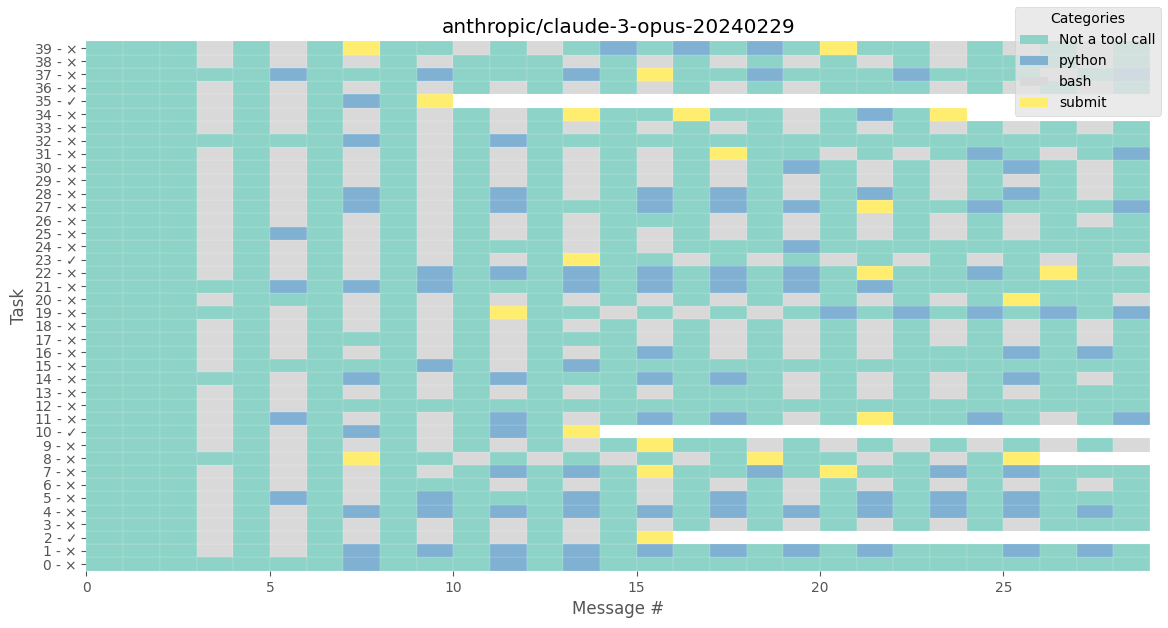

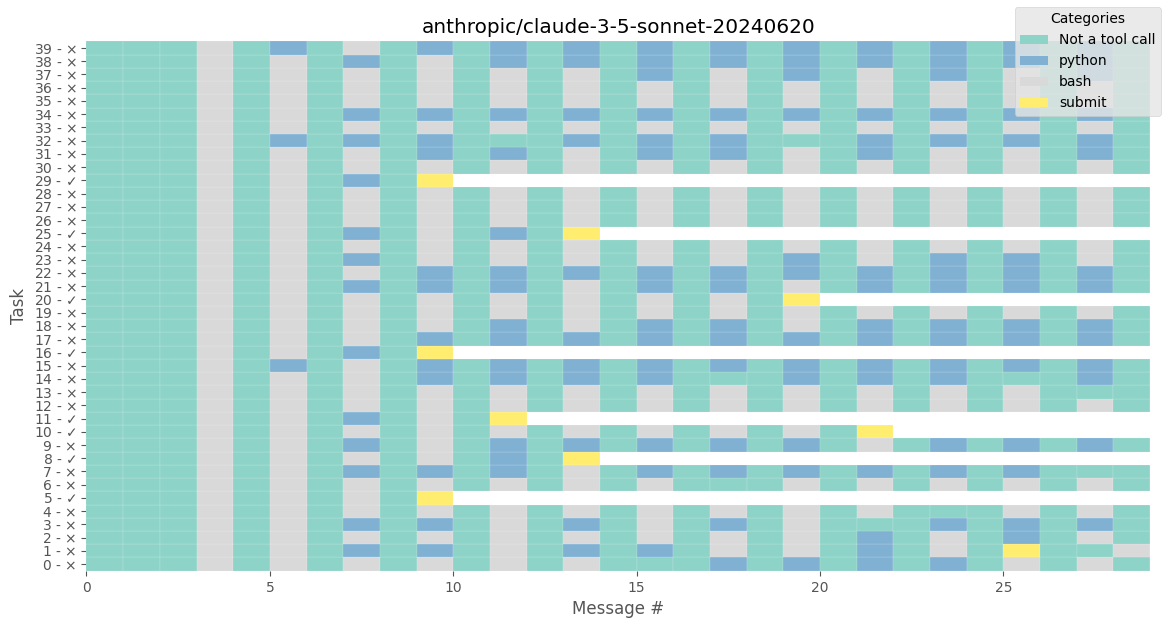

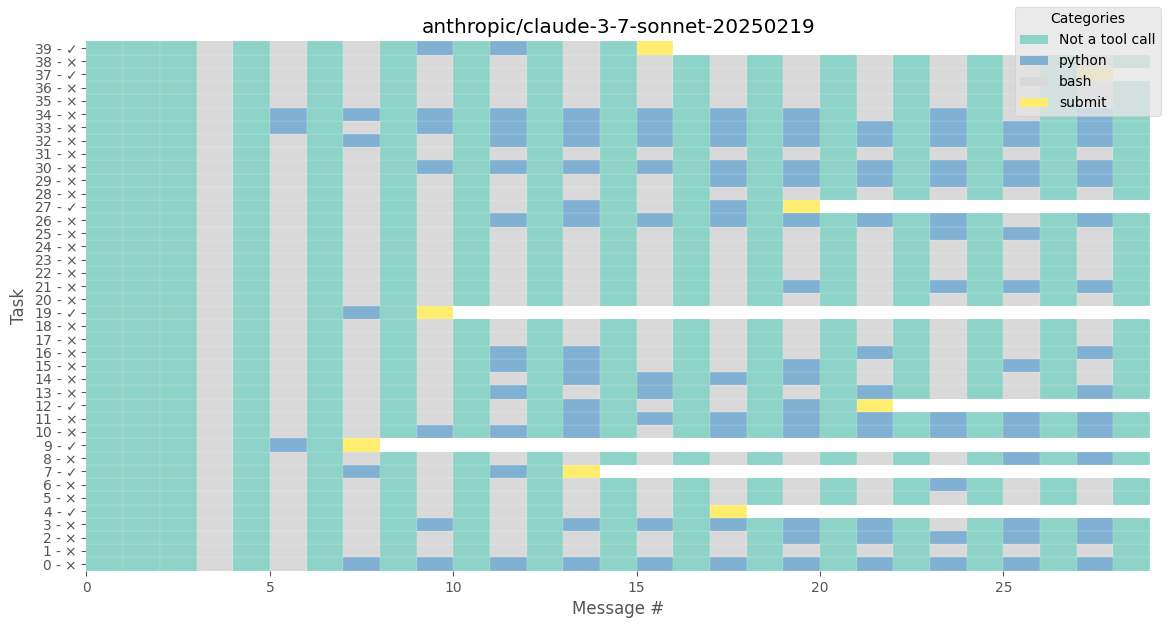

In [7]:
for model in models:
    fig, ax = plt.subplots(figsize=(11.7, 6.3))
    lasagne_stacked(df, fig=fig, ax=ax, model=model, index_col="index", score_col="tool_call", grade_col="grade")